In [35]:
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from transformers import *
import numpy as np
from collections import defaultdict

# ***Reading the Dataset***

In [2]:
data = pd.read_csv("./data/IMDB_Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [47]:
sns.set(rc={'axes.facecolor':'#FAF7CC',"axes.edgecolor":"black","axes.grid":False,"axes.labelsize":30,"xtick.labelsize":15,"ytick.labelsize":15})

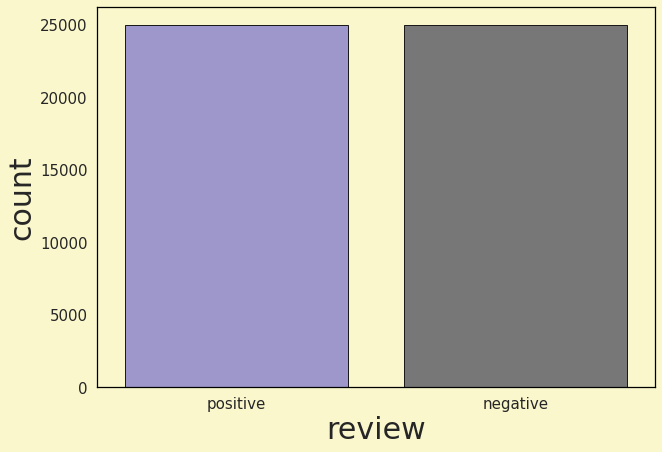

In [4]:
fig, axes = plt.subplots(nrows = 1, ncols =1, figsize = (10, 7),facecolor='#FAF7CC')
sns.countplot(x="sentiment",data=data,palette=["#988ed5", "#777777"],edgecolor="k")
plt.xlabel('review')
plt.show()

# ***Data Preprocessing***

In [5]:
data['sentiment'] = data['sentiment'].apply(lambda x: 1 if x=='positive' else 0)

#### Importing BERT pretrained model tokenizer :

In [6]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [7]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

#### Special tokens:

marker for ending of a sentence :

In [8]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

classification token at the start of each sentence, so BERT knows we're doing classification

In [9]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

padding token :

In [10]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

unkown token :

In [11]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

#### Precising the max length for BERT tokenizer :
In order to get the suitable max sequence length we need to take a look at all reviews lengths after tokenization and then select the most appropriate one (for now we will set the max_length to an upper bound of 2000)


In [12]:
def token_len(review):
    return(len(tokenizer.encode(review, max_length=2000,truncation=True)))

In [13]:
data_length=data['review'].apply(token_len)

/home/dhiab/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


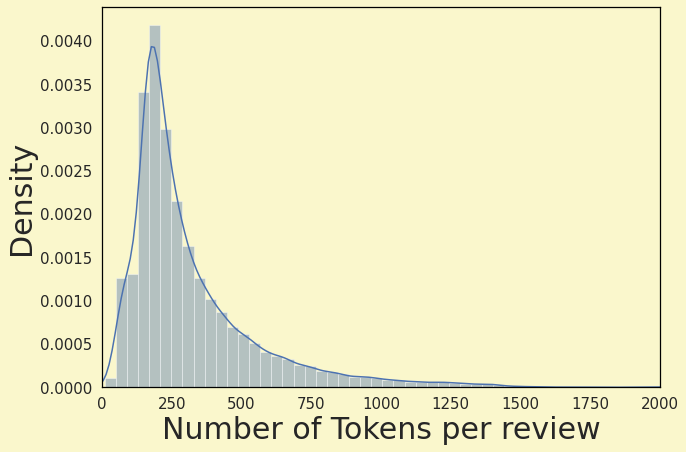

In [14]:
fig, axes = plt.subplots(nrows = 1, ncols =1, figsize = (10, 7),facecolor='#FAF7CC')
sns.distplot(data_length)
plt.xlim([0, 2000]);
plt.xlabel('Number of Tokens per review');

#### $\longrightarrow$ We can clearly see that the average length of tokenized reviews is around 200-300 therefore we will set MAX_LENGTH to 256

In [15]:
MAX_LEN = 256      #for not consuming much resources
RANDOM_SEED = 40
device = torch.device( 'cuda' )

In [16]:
from sklearn.model_selection import train_test_split
#doing the split of the dataset into training, validation and testing sets
data_train, data_test = train_test_split(data, test_size=0.1, random_state=RANDOM_SEED)
data_val, data_test = train_test_split(data_test, test_size=0.5, random_state=RANDOM_SEED)

In [17]:
data_train.shape, data_val.shape, data_test.shape

((45000, 2), (2500, 2), (2500, 2))

# ***Creating Dataset and Dataloader using `torch.utils.data`***

In [18]:
from torch.utils.data import Dataset, DataLoader

class IMDBDataset(Dataset):

  def __init__(self, reviews, sentiments, tokenizer, max_len):
    self.reviews = reviews
    self.sentiments = sentiments
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    sentiment = self.sentiments[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'sentiments': torch.tensor(sentiment, dtype=torch.long)
    }

In [19]:
def create_data_loader(data, tokenizer, max_len, batch_size):
  ds = IMDBDataset(
    reviews=data.review.to_numpy(),
    sentiments=data.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

BERT authors recommendations for fine-tuning :

    * Batch size: 16, 32
    * Learning rate (Adam): 5e-5, 3e-5, 2e-5
    * Number of epochs: 2, 3, 4

We’re going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

In [20]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(data_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(data_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(data_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [21]:
#taking one batch of the training data
model_data = next(iter(train_data_loader));
model_data.keys()

dict_keys(['review', 'input_ids', 'attention_mask', 'sentiments'])

In [22]:
print(f"input ids shape  :  {model_data['input_ids'].shape}")
print(f"attention mask shape  :  {model_data['attention_mask'].shape}")
print(f"sentiments shape  :  {model_data['sentiments'].shape}")

input ids shape  :  torch.Size([8, 256])
attention mask shape  :  torch.Size([8, 256])
sentiments shape  :  torch.Size([8])


# ***Building the Sentiment Classifier using BERT from Huggingface***

We'll use the basic BertModel `bert-base-cased` and build our sentiment classifier on top of it

In [23]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [24]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the ***BertModel***. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the ***cross-entropy loss*** function in `PyTorch` to work.

Like any other PyTorch model, we first create an instance of the model and then move it to the GPU:

In [25]:
class_names=['negative','positive']
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [26]:
input_ids = model_data['input_ids']
attention_mask = model_data['attention_mask']

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 256])
torch.Size([8, 256])


# ***Train and Evaluate***

In [27]:
EPOCHS = 2

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [28]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["sentiments"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

* The scheduler gets called every time a batch is fed to the model. 

* We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

In [31]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["sentiments"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [30]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(data_train)
  )

  print(f'Train loss {train_loss:.3f} accuracy {train_acc:.3f}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(data_val)
  )

  print(f'Val   loss {val_loss:.3f} accuracy {val_acc:.3f}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/1
----------
Train loss 0.659 accuracy 0.571


KeyError: 'targets'

# ***Testing the Model***

In [37]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(data_test)
)

print(f'Model Test Accuracy :   {test_acc.item():.3f}')

Model Test Accuracy :   0.812


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs using `probs = F.softmax(outputs, dim=1)`

In [42]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["sentiments"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

# ***Classification Report and Confusion Matrix***

Using the review texts of the test set as well as the built-in functions `confusion_matrix` and `classification_report` of `sklearn` we plot both the ***Classification Report*** as well as the ***Confusion Matrix***

In [137]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [138]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.83      0.80      0.81      1277
    positive       0.80      0.83      0.81      1223

    accuracy                           0.81      2500
   macro avg       0.81      0.81      0.81      2500
weighted avg       0.81      0.81      0.81      2500



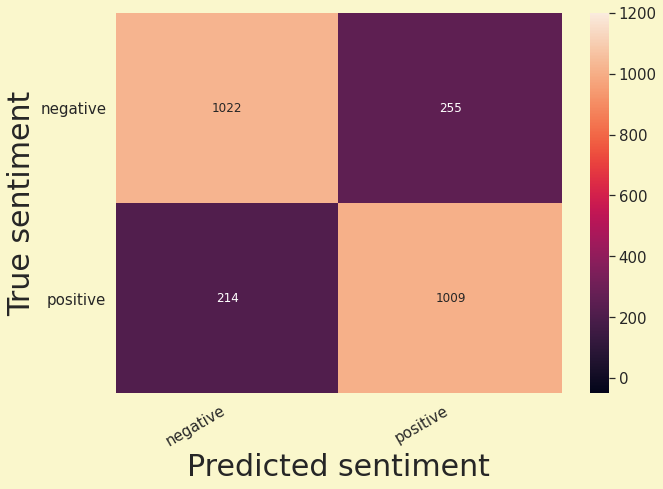

In [139]:

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="rocket",linecolor="red",vmin=-50,vmax=1200)
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
fig, axes = plt.subplots(nrows = 1, ncols =1, figsize = (10, 7),facecolor='#FAF7CC')
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# ***Predicting the sentiment of an example review***

In [140]:
review_text = "I love NLP but I hate using BERT with budget GPU "

In [141]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


In [142]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love NLP but I hate using BERT with budget GPU 
Sentiment  : negative
